# qCBR, learning by cases

A supervised classifier can be interpreted as a program capable of predicting the output of input from the labelled data. From the input data and the label, with known examples, we will be able to, which will be the label given new input.

The main idea of quantum Case-Based Reasoning (qCBR)[1] is to interpret the statement of the problem as an input and the solution to the problem as an output. Therefore, if we have a series of situations with their outcomes, we can train our classifier to determine its solution given a new problem.

<img src="https://raw.githubusercontent.com/pifparfait/qCBR/master/qCBR_1.png" width=300 height=600 class="center" />

The first step is to determine how to code a problem for input. In the case of Maxcut, the statement of a problem is perfectly defined by its adjacency matrix; therefore, we can have this matrix as the statement of the problem, which will be the input of our qCBR.

<img src="https://raw.githubusercontent.com/pifparfait/qCBR/master/qCBR_2.png" width=600 height=600 class="center"/>


We will only focus on the classifier throughout this notebook, but the qCBR follows a slightly more complicated process following human reasoning.

<img src="https://raw.githubusercontent.com/pifparfait/qCBR/master/qCBR_B.png" class="center" />

The qCBR cycle can be summarised in four steps: 
- (1) **Retrieval** of the most similar cases, 
- (2) **Re-use (Adaptation)** to those cases to propose a new solution to the new environment, 
- (3) **Revise (Validity)** check of the proposed solution and finally, 
- (4) **Retain (Storage)** following a learning policy.


If one of the data that we find in the memory of the cases, we can interpret it to solve the problem or with a certain probability, we solve it to see if the solution ends up improving.


[1]: https://arxiv.org/abs/2104.00409 

In [1]:
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import networkx as nx

%config InlineBackend.figure_format = 'retina'# making nice plot

qCBR_input = np.load("qCBR_input.npy")
qCBR_output = np.load("qCBR_output.npy")

## The qCBR classifier.

We have designed a classifier that emulates neural networks solving the function $Wx + b$, with $W$ and $b$ the parameters and $x$, the sample data to be classified. The non-linearity of the quantum gates is used to implement the activation function $f (Wx + b)$ given $Wx + b$. The figure provides us with the block diagram of the classifier. The optimization and parameters' $(W, b)$ actualization are done in the first step, MSE between ($\bar y$ and $y$), where $y$ is the label associated with $x$ and $k$ of the labels.

<img src="https://raw.githubusercontent.com/pifparfait/qCBR/master/Classifiers_Gen.png" width=600 height=600 />

The detailed operations of the classifier are given by the figure where the quantum gates, $R_{y}$, $R_{x}$ and $C_{RZ}$ are used to define the block.

<img src="https://raw.githubusercontent.com/pifparfait/qCBR/master/Classifiers_details.png"  />

In [2]:
NUM_EPOCHS = 70 #Number of epochs

p = 0.5  # probability of an edge
seed = 396 #400 392 200

n_nodes = 5
n_samples = len(qCBR_input)
n_test = int(0.1 * n_samples)

n_blocks = 2 # Number of blocks
n_labels = 2**n_nodes # number of labels
n_features = n_nodes**2 # dataset attributes
n_qubits = n_nodes

The layer definition

In [3]:
def layers(w, b, x):
    # We define the block
    #print ("Printing x", x)
    for i in range(n_qubits):
        qml.RX(np.dot(w[i], x) + b[i], wires = i)
        qml.RZ(np.dot(w[i], x) + b[i], wires = i)
        qml.CRZ(np.dot(w[i], x) + b[i], wires = [i, (i-1) % n_qubits])

 Definition of our qCBR variational classifier circuit

In [4]:
dev = qml.device("default.qubit", wires = n_qubits)

@qml.qnode(dev)
def circuit_qCBR(W,B,x):
    # This will be the entire circuit
    for i in range(n_blocks):
        layers(W[i], B[i], x)
    return [qml.probs(wires = i) for i in range(n_qubits)] 

Definition of our cost function. In this demo, we are using the MSE, but we can use another more appropriate to the problem we need to solve. 

This error can be improved by playing with the corresponding energy with the solution;  however, we rely on the MSE in this tutorial.

In [5]:
def total_error(W, B, x, labels):
    err = 0
    for i_data, i_label in zip(x, labels):
        err += error(W, B, i_data, i_label)
    return err / len(labels)

def error(W,B,i_data, i_label):
    sol = np.array([pr[0] for pr in circuit_qCBR(W, B, i_data)], requires_grad = True)
    out =  np.square(np.subtract(sol, i_label)).mean()
    return out

## Optimization
The learning process and at the end, we plot the train and test graphs.
After the previous steps, now we need to pick an optimizer and run the standard optimization loop. In this tutorial we use the *GradientDescentOptimizer* but the user could find more option here: [optimizers in pennylane](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html "optimizers") 



In [6]:
def Comparative_graphs(x_train, labels_train, x_test, labels_test):
    
    #opt = qml.GradientDescentOptimizer(stepsize = 0.22)
    opt=  qml.AdamOptimizer(stepsize=0.01, beta1=0.9, beta2=0.99, eps=1e-08)
    epochs = NUM_EPOCHS

    train_error = []
    test_error = []
    
    np.random.seed(seed)

    x_train = np.array(x_train, requires_grad = False)
    labels_train = np.array(labels_train, requires_grad = False)
    W = np.random.rand(n_blocks, n_qubits, n_features, requires_grad = True)
    B = np.random.rand(n_blocks, n_qubits, requires_grad = True )
    
    for epoch in range(epochs):
        W, B, _, _ = opt.step(total_error, W, B, x_train, labels_train)
        train_error.append(total_error(W,B,x_train, labels_train))
        test_error.append(total_error(W,B,x_test, labels_test))
        res = [epoch + 1, train_error[epoch], test_error[epoch], 1-train_error[epoch],1-test_error[epoch]]
        print("Epoch: {:2d} | Train error: {:3f} | Test error: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))
        
    plt.style.use("seaborn")
    plt.plot(train_error, label = "train error")
    plt.plot(test_error, label = "test error")
    plt.legend()
    plt.show()
    
    return W,B

In [7]:
def split_train_test(qCBR_dataset, labels, test_size=0.25):
    N_TEST = int(n_samples * test_size)

    x_test = qCBR_dataset[:n_test]
    x_train = qCBR_dataset[n_test:]
    labels_test = labels[:n_test]
    labels_train = labels[n_test:]

    return x_train, x_test, labels_train, labels_test
    
x_train, x_test, labels_train, labels_test = split_train_test(qCBR_input, qCBR_output)


## Let us train our classifier and prepare it for the test.
First, we compare our test and train error, and later we plot the two graphs.

Epoch:  1 | Train error: 0.323482 | Test error: 0.370004 | Train accuracy: 0.676518 | Test accuracy: 0.629996
Epoch:  2 | Train error: 0.304458 | Test error: 0.346477 | Train accuracy: 0.695542 | Test accuracy: 0.653523
Epoch:  3 | Train error: 0.286213 | Test error: 0.321067 | Train accuracy: 0.713787 | Test accuracy: 0.678933
Epoch:  4 | Train error: 0.269217 | Test error: 0.295193 | Train accuracy: 0.730783 | Test accuracy: 0.704807
Epoch:  5 | Train error: 0.253754 | Test error: 0.270594 | Train accuracy: 0.746246 | Test accuracy: 0.729406
Epoch:  6 | Train error: 0.239902 | Test error: 0.248989 | Train accuracy: 0.760098 | Test accuracy: 0.751011
Epoch:  7 | Train error: 0.227620 | Test error: 0.231981 | Train accuracy: 0.772380 | Test accuracy: 0.768019
Epoch:  8 | Train error: 0.216984 | Test error: 0.220580 | Train accuracy: 0.783016 | Test accuracy: 0.779420
Epoch:  9 | Train error: 0.208300 | Test error: 0.214638 | Train accuracy: 0.791700 | Test accuracy: 0.785362
Epoch: 10 

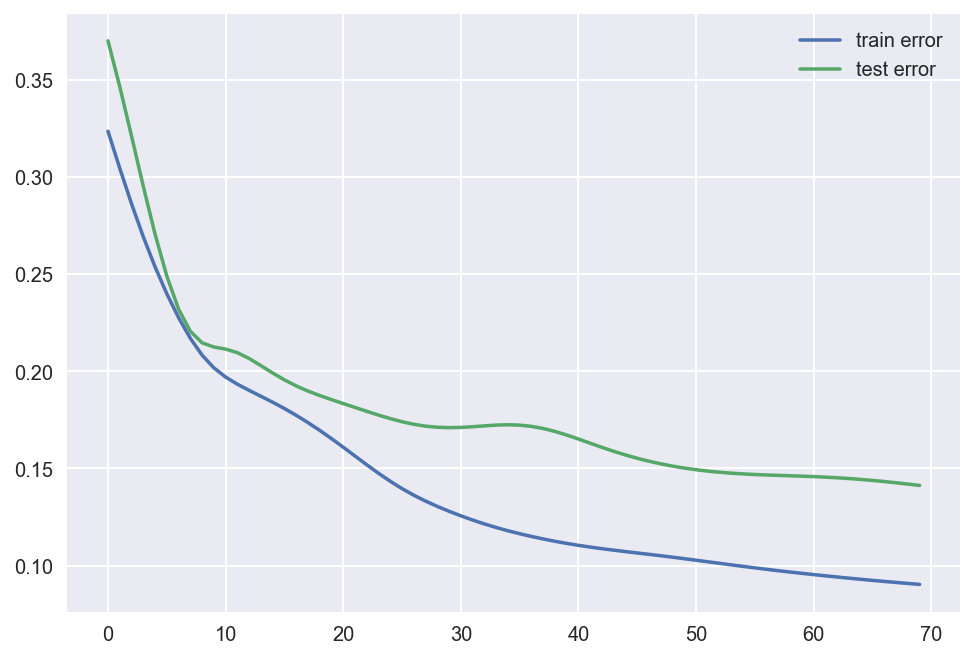

In [8]:
W,B = Comparative_graphs(x_train, labels_train, x_test, labels_test)

In this tutorial, we will not implement the whole synthesizer block. We only test if the predicted new value is well retrieved.

In [9]:
# new Problem
p = 0.5  # probability of an edge
g_new = nx.erdos_renyi_graph(n_nodes, p=p,seed=8)
positions_new = nx.spring_layout(g_new)

def Transform_Label_To_Node (tmp_label):
    labels_nodes_tmp = []
    for i in range(len(tmp_label)):
        if tmp_label[i] == "1":
            labels_nodes_tmp.append(i)
            
    return labels_nodes_tmp

In [10]:
labels_map = [bin(i)[2:].zfill(n_nodes) for i in range((2**n_nodes))]


def max_prob_sol():
    tmp =0
    tp = 0
    for i in range (n_nodes):
        prob_circuit_new_tmp = circuit_qCBR(W,B,x_test[i])
        out_new_X_tmp = np.argmax(prob_circuit_new_tmp)
        index_label_new = labels_map[out_new_X_tmp]
        qCBR_labels_nodes_tmp = Transform_Label_To_Node (index_label_new)
        tp = len(qCBR_labels_nodes_tmp)
        if(tmp<= tp):
            tmp =  tp
            qCBR_labels_nodes=qCBR_labels_nodes_tmp
            
    return qCBR_labels_nodes

max_prob_sol()

[2, 3, 4]

Let us plot the solution from the qCBR

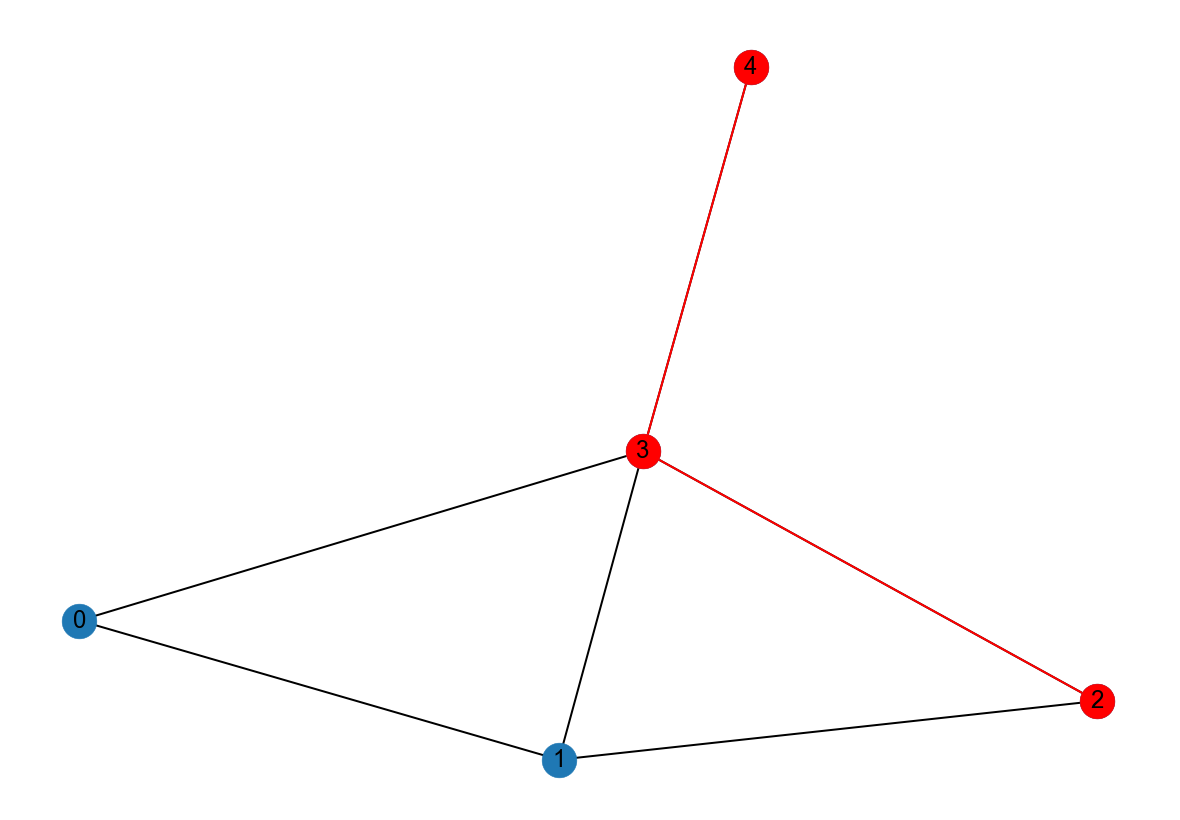

In [11]:
sub = g_new.subgraph(max_prob_sol())
nx.draw(g_new, pos=positions_new, with_labels=True)
nx.draw(sub, pos=positions_new, node_color="r", edge_color="r")

## Notes
If the end-user wants to change the input data, he can go to the root directory. Otherwise, it could generate its own problem. You should only encode the issue in an adjacent matrix, pass it in a flattened vector and provide the associated solution. In the case of wanting to train

## References:
[1] https://arxiv.org/abs/2104.00409 